# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, lin_reg, simulate_quant_trait
from models import no_corr, rare_pc, pc, gc, abyss_bottle_linreg, abyss_maf_linreg, deep_abyss_bottle_linreg, deep_abyss_maf_linreg, deep_abyss_pred_linreg
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

warnings.filterwarnings("ignore")

2024-07-02 13:05:44.500325: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 13:05:44.508783: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 13:05:44.532392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 13:05:44.578432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 13:05:44.578513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 13:05:44.612080: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks"
}

# Load genotype

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [4]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

'NW_risk'

In [5]:
nr_common_PCs = 25
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
nr_rare_PCs = 25
rare_pc_columns = ['PC{}'.format(i) for i in range(1, nr_rare_PCs+1)]

In [6]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [7]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)

# Load environmental risk

In [8]:
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")

# Create phenotype only ENV dependent

In [9]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk])))
risk['pheno'] = y
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

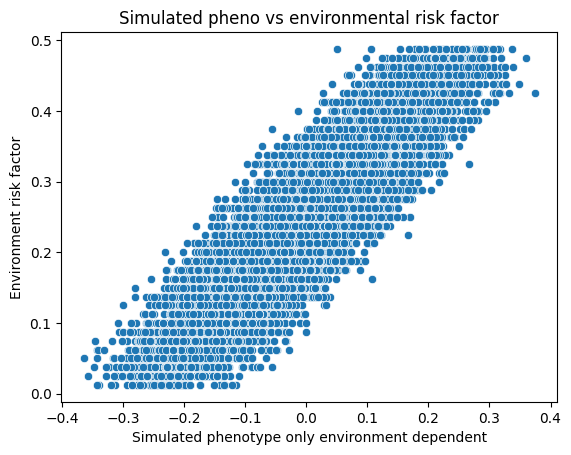

In [10]:
sns.scatterplot(x=list(y), y=list(np.array(risk[name_risk])))
plt.xlabel('Simulated phenotype only environment dependent')
plt.ylabel('Environment risk factor')
plt.title('Simulated pheno vs environmental risk factor')
plt.show()

# Analysis

In [11]:
# No correction
df_no_corr = no_corr(complete, y)

In [12]:
# rare PCA
PC_veryrare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
df_rare_PCs = rare_pc(complete, y , PC_veryrare, rare_pc_columns)

In [13]:
# PCA
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
df_PCs = pc(complete, y , PC_common, pc_columns)

In [14]:
# Genomic control
df_GC = gc(df_no_corr)

In [15]:
# minimalist abyss
bottleneck_nr = 2
epoch = 100
patience = 20
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(complete*2 - 1, bottleneck_nr, epoch, patience)
# Extract the bottleneck layer after fitting the model
bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)

abyss_bottle = bottleneck_model(tf.convert_to_tensor(complete*2 - 1, dtype=tf.float32))
abyss_MAF = autoencoder(tf.convert_to_tensor(complete*2 - 1, dtype=tf.float32))
p = (pd.DataFrame(data=abyss_MAF, columns = complete.columns)+1)/2
q = 1-p
abyss_maf_correction = p-q
df_abyss_bottle = abyss_bottle_linreg(complete, y, abyss_bottle)
df_abyss_maf = abyss_maf_linreg(complete, y, abyss_maf_correction)

In [16]:
# deep abyss
bottleneck_nr = 24
epoch = 100
patience = 20
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]

deep_autoencoder, deep_bottleneck_model, deep_history = deep_abyss(complete*2 - 1, bottleneck_nr, epoch, patience, risk[['pheno']])
[deep_abyss_MAF, deep_abyss_pred] = deep_autoencoder(tf.convert_to_tensor(complete*2 - 1, dtype=tf.float32))
deep_abyss_bottle = deep_bottleneck_model(tf.convert_to_tensor(complete*2 - 1, dtype=tf.float32))
p_deep = (pd.DataFrame(data=deep_abyss_MAF, columns = complete.columns)+1)/2
q_deep = 1-p_deep
deep_abyss_maf_correction = p_deep-q_deep
df_deep_abyss_bottle = deep_abyss_bottle_linreg(complete, y, deep_abyss_bottle)
df_deep_abyss_maf = deep_abyss_maf_linreg(complete, y, deep_abyss_maf_correction)
df_deep_abyss_pred = deep_abyss_pred_linreg(complete, y, deep_abyss_pred)

In [17]:
temp1 = pd.merge(df_no_corr, df_rare_PCs, left_index=True, right_index=True)
columns_to_drop = temp1.filter(regex='(_x|_y)$').columns
temp1 = temp1.drop(columns=columns_to_drop)
temp2 = pd.merge(df_PCs, df_GC, left_index=True, right_index=True)
columns_to_drop = temp2.filter(regex='(_x|_y)$').columns
temp2 = temp2.drop(columns=columns_to_drop)
temp3 = pd.merge(df_abyss_bottle, df_abyss_maf, left_index=True, right_index=True)
columns_to_drop = temp3.filter(regex='(_x|_y)$').columns
temp3 = temp3.drop(columns=columns_to_drop)

temp4 = pd.merge(df_deep_abyss_bottle, df_deep_abyss_maf, left_index=True, right_index=True)
columns_to_drop = temp4.filter(regex='(_x|_y)$').columns
temp4 = temp4.drop(columns=columns_to_drop)

In [18]:
temp12 = pd.merge(temp1, temp2, left_index=True, right_index=True)
temp34 = pd.merge(temp3, temp4, left_index=True, right_index=True)
final_merged = pd.merge(temp12, temp34, left_index=True, right_index=True)

In [19]:
final_merged = pd.merge(final_merged, df_deep_abyss_pred, left_index=True, right_index=True)
final_merged

,Ps_no_corr,logPs_no_corr,Ps_rare_PCs,logPs_rare_PCs,Ps_common_PCs,logPs_common_PCs,Ps_GC,logPs_GC,Ps_abyss_bottle,logPs_abyss_bottle,...,Ps_deep_abyss_bottle,logPs_deep_abyss_bottle,Ps_deep_abyss_maf,logPs_deep_abyss_maf,coeff,AFs,Ps_deep_abyss_pred,expected_P,logPs_deep_abyss_pred,expected_logP
0,0.000000,0.002492,0.000000,0.011722,2.300343e-28,0.000382,1.0,-0.0,4.523476e-50,0.002368,...,6.313889e-18,0.000777,1.271275e-197,0.008081,0.010465,0.296425,0.000000e+00,0.001159,0.000616,-0.000000
1,0.000000,0.002658,0.000000,0.023012,4.711502e-21,0.001990,1.0,-0.0,2.118093e-49,0.002395,...,2.207612e-14,0.002442,4.340233e-196,0.008153,-0.015597,0.21885,0.000000e+00,0.002317,0.006222,0.000504
2,0.000000,0.006025,0.000000,0.026116,2.466526e-18,0.004139,1.0,-0.0,1.156189e-45,0.003913,...,2.109858e-11,0.002484,4.032846e-184,0.013968,0.000696,0.21275,6.231033e-287,0.003476,0.010674,0.001008
3,0.000000,0.020034,0.000000,0.058982,4.083194e-17,0.004687,1.0,-0.0,1.059386e-41,0.004050,...,3.568335e-10,0.003208,2.824841e-169,0.014911,-0.000253,0.2368,1.135773e-240,0.004635,0.013243,0.001512
4,0.000000,0.024043,0.000000,0.079605,2.727467e-14,0.006726,1.0,-0.0,3.530382e-40,0.007041,...,3.897888e-10,0.004160,3.086683e-157,0.016426,-0.018348,0.217525,5.580943e-231,0.005794,0.015235,0.002018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,0.946144,100.000000,0.832520,100.000000,9.846320e-01,13.564241,NaN,NaN,9.839184e-01,39.452178,...,9.904674e-01,9.409171,9.628838e-01,100.000000,0.017417,0.016075,9.655286e-01,0.995365,100.000000,2.237041
859,0.954918,100.000000,0.873007,100.000000,9.892650e-01,16.389000,NaN,NaN,9.907172e-01,40.974946,...,9.926404e-01,9.447534,9.662490e-01,100.000000,-0.003303,0.0108,9.699666e-01,0.996524,100.000000,2.333951
860,0.986222,100.000000,0.941637,100.000000,9.905153e-01,17.607914,NaN,NaN,9.910303e-01,44.936971,...,9.942969e-01,10.675747,9.683492e-01,100.000000,0.008778,0.008,9.757213e-01,0.997683,100.000000,2.458890
861,0.993899,100.000000,0.948392,100.000000,9.954285e-01,20.326841,NaN,NaN,9.945015e-01,48.674055,...,9.943930e-01,13.656077,9.814016e-01,100.000000,-0.028779,0.010525,9.857745e-01,0.998841,100.000000,2.634981


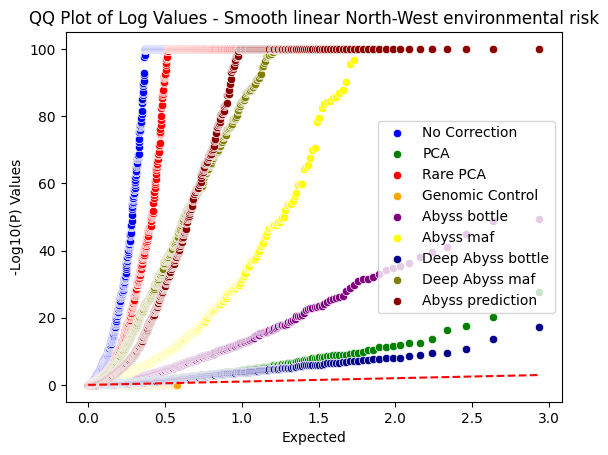

In [20]:
# Plot log10_p_no_corr
sns.scatterplot(x='expected_logP', y='logPs_no_corr', data=final_merged, color='blue', label='No Correction')

# Plot log10_p_PCs
sns.scatterplot(x='expected_logP', y='logPs_common_PCs', data=final_merged, color='green', label='PCA')

# Plot log10_p_rare_PCs
sns.scatterplot(x='expected_logP', y='logPs_rare_PCs', data=final_merged, color='red', label='Rare PCA')

sns.scatterplot(x='expected_logP', y='logPs_GC', data=final_merged, color='orange', label='Genomic Control')

sns.scatterplot(x='expected_logP', y='logPs_abyss_bottle', data=final_merged, color='purple', label='Abyss bottle')

sns.scatterplot(x='expected_logP', y='logPs_abyss_maf', data=final_merged, color='yellow', label='Abyss maf')

sns.scatterplot(x='expected_logP', y='logPs_deep_abyss_bottle', data=final_merged, color='darkblue', label='Deep Abyss bottle')

sns.scatterplot(x='expected_logP', y='logPs_deep_abyss_maf', data=final_merged, color='olive', label='Deep Abyss maf')

sns.scatterplot(x='expected_logP', y='logPs_deep_abyss_pred', data=final_merged, color='darkred', label='Abyss prediction')



# Plot diagonal reference line
plt.plot([min(final_merged['expected_logP']), max(final_merged['expected_logP'])], 
         [min(final_merged['expected_logP']), max(final_merged['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

# Check output of everything

In [22]:
bottle_df = pd.DataFrame(deep_abyss_bottle, columns=dim_columns)
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
populations['population'] = populations['population_number']/(k*k)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
bottle_df[to_have_collumns] = populations[to_have_collumns]

In [23]:

# Function to calculate entropy of a column
def calculate_entropy(column):
    counts = column.value_counts()
    return entropy(counts)

temp = bottle_df.round(2)
# Calculate entropy for each column
entropy_values = temp.apply(calculate_entropy)

# Rank the columns based on entropy
ranked_columns_entropy = entropy_values.sort_values(ascending=False)
most_explaining_dims = list(ranked_columns_entropy.keys())
most_explaining_dims = [f for f in most_explaining_dims if f.startswith('dim')]

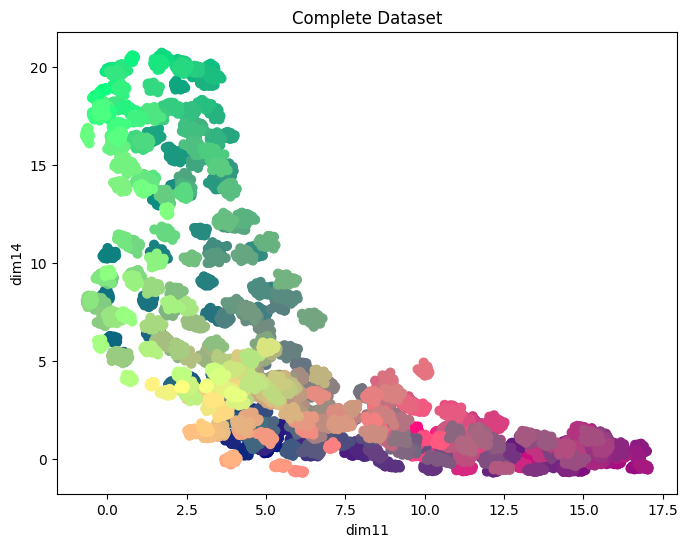

In [24]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df[most_explaining_dims[0]], y=bottle_df[most_explaining_dims[1]], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[0]}")
plt.ylabel(f"{most_explaining_dims[1]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

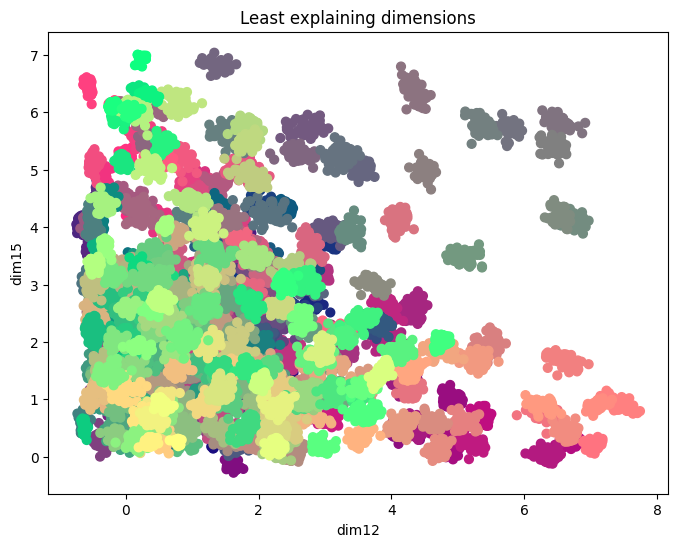

In [25]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df[most_explaining_dims[-1]], y=bottle_df[most_explaining_dims[-2]], c=colors, s=40)

plt.title('Least explaining dimensions')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[-1]}")
plt.ylabel(f"{most_explaining_dims[-2]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

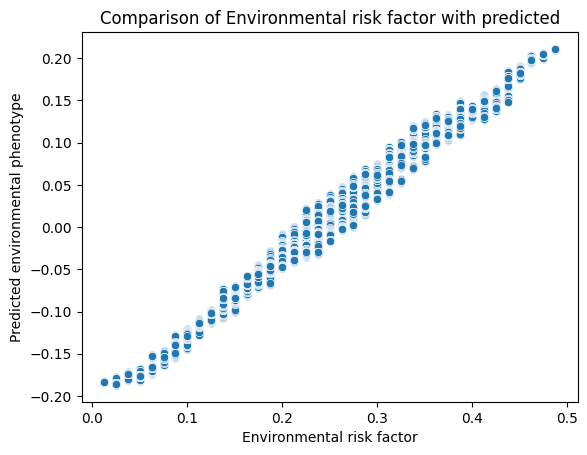

In [26]:
sns.scatterplot(x=list(risk[name_risk]), y=list(np.array(deep_abyss_pred).flatten().tolist()))
plt.xlabel('Environmental risk factor')
plt.ylabel('Predicted environmental phenotype')
plt.title('Comparison of Environmental risk factor with predicted')
plt.show()

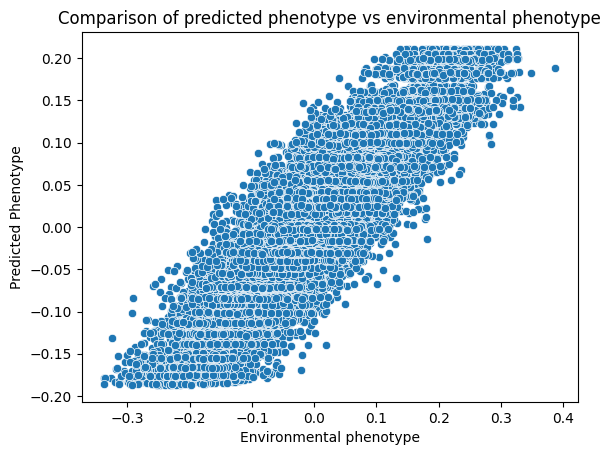

In [27]:
sns.scatterplot(x=list(y), y=list(np.array(deep_abyss_pred).flatten().tolist()))
plt.xlabel('Environmental phenotype')
plt.ylabel('Predicted Phenotype')
plt.title('Comparison of predicted phenotype vs environmental phenotype')
plt.show()